In [349]:
#==== Python code on 1D Helium plasma, (7-11-2017) ====
#==================Saurav Gautam=========================
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse

def poissonmatrix(nxp, k1=-1, k2=0, k3=1):
    a = np.ones(nxp)*(2.0)
    b = np.ones(nxp-1)*(-1)
    return np.diag(b, k1) + np.diag(a, k2) + np.diag(b, k3)
    
def tridiagSparse(nxp, k1=-1, k2=0, k3=1):
    a = np.ones(nxp)*(-1)
    b = np.ones(nxp)*(2)
    return sparse.dia_matrix(([a,b,a],[k1,k2,k3]),shape=(nxp,nxp)).tocsc()

def SparseLaplacianOperator(nx,k1=-1,k2=0,k3=1):
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=1
    d2[1:-1]=-2
    d3[2:]=1
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )

def readBoltzmannParameters(npoints,oupfile='output.txt'):
    #print('*** Importing the value of MOBILITY, DIffusion and reaction rate from a text file')
    emobility=np.zeros(npoints,float)
    ediffusion=np.zeros(npoints,float)
    esourcee=np.zeros(npoints,float)
    imobility=np.zeros(npoints,float)
    idiffusion=np.zeros(npoints,float)
    file=open(oupfile)
    line=file.readline()
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       emobility[data]=float(lineSplit[1])
    line=file.readline(); line=file.readline();
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       ediffusion[data]=float(lineSplit[1])
    line=file.readline(); line=file.readline();
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       esourcee[data]=float(lineSplit[1])
    line=file.readline(); line=file.readline();
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       imobility[data]=float(lineSplit[1])
    line=file.readline(); line=file.readline();
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       idiffusion[data]=float(lineSplit[1]) 
    return(emobility,ediffusion,esourcee,imobility/0.12*1.6,idiffusion/0.12*1.6)

      
def fourPlots(ones,titleone,two,titletwo,three,titlethree,four,titlefour):      
        f, axarr = plt.subplots(2, 2)
        for field in ones:
            axarr[0,0].plot(field);
        #axarr[0,0].set_title(titleone)       
        axarr[0,1].plot(netcharge)
        axarr[0,1].set_title(titletwo)
        axarr[1,1].plot(potentl)
        axarr[1,1].set_title(titlethree)       
        axarr[1,0].plot(efield)      
        axarr[1,0].set_title(titlefour)
        f.subplots_adjust(hspace=0.3)
        plt.show()
        
def SparseDiffusionOperator(source,ne,dif,dx,dt,k1=-1,k2=0,k3=1):
    nx=dif.size
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=(dt/(4*dx*dx))*(dif[2:]-dif[:-2]-4*dif[1:-1])
    d2[1:-1]=(1-0*dt*source[1:-1]*ne[1:-1]+2*dt*dif[1:-1]/(dx**2))
    d3[2:]=(dt/(4*dx*dx))*(-dif[2:]+dif[:-2]-4*dif[1:-1])
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )


def SparseAdvectionOperatorAndSource(source,ne,dx,dt,vi,k1=-1,k2=0,k3=1):
    nx=vi.size
    vi[0]=0.; vi[-1]=0.
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=(dt/dx)*(-0.75*vi[:-2]-0.25*vi[1:-1])
    d2[1:-1]=(1-0*dt*source[1:-1]*ne[1:-1]+(dt/dx)*(0.25*vi[:-2]+0.5*vi[1:-1]+0.25*vi[2:]))
    d3[2:]=(dt/dx)*(0.25*vi[1:-1]-0.25*vi[2:])
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )



parameterSize=996       
(emobility,ediffusion,esourcee,imobility,idiffusion) = readBoltzmannParameters(parameterSize,'output.txt')


#*** Parameters for the of plasma reactor
#-------------------------------------------------------------------------------------------------------------
width=3.0     #space between two dielectric in mm
ngrid0=300     #Number of grid points (between two dielectric)
wd1=1.8        #width of first dielectric in mm
wd2=1.8       #width of second dielectric in mm
dx=width*1e-3/(ngrid0+1.0)#Grid size in meter
nwd1=int(wd1*1e-3/dx)       #number of grid points in first dielectric
nwd2=int(wd2*1e-3/dx)       #Number of grid points in second dielectric
wd1=nwd1*dx                 #Making wd1 as exact multiple of dx
wd2=nwd2*dx                 #making wd2 as exact multiple of dx
inelec=width*1e-3+wd1+wd2#total interelectrode separation
ngrid=int(ngrid0+2+nwd1+nwd2)    #total number of grid points(2 dielectrics +gas medium + all edge points)
#--------------------------------------------------------------------------------------------------------------
volt=3000.0    #Interelectrode voltage (peak not RMS)
gasdens=2.504e25          #number density of gas at NTP (unit: m^-3)
dt=1.0e-9 #small tyme interval
frequencySource = 41000 #40KHz
ee=1.6*1e-19 #electronic charge
e0=8.54187817*1e-12 #epsilon
townsendunit=1.0/((gasdens)*(1e-21))
Kboltz=1.380*1e-23

#*** Initialization
#-----------------------------------------------------------------------------------------------------
ns=2          #Number of species (Taking helium gas, one is electron and another is helium ion)
ndensity=np.zeros((ns,ngrid0+2),float) #Density of each species in all grid points between dielectric
ncharge=np.array([-1,1])  #Charge of the each species
netcharge=np.zeros(ngrid,float) #net charge at all grid points used to solve poission equation
potentl=np.zeros(ngrid,float) #potential at each grid points
uu=np.zeros(ngrid,float) #potential at each grid points
efield=np.zeros(ngrid0+2,float) #electric field at each grid points
mobegrid=np.zeros(ngrid0+2,float)#mobility at grid points, 1 row=1 tyepe of gaseous species
difegrid=np.zeros(ngrid0+2,float)#diffusion coefficient at each grid points
sourceegrid=np.zeros(ngrid0+2,float)#reaction rate at each grid points
mobigrid=np.zeros(ngrid0+2,float)
difigrid=np.zeros(ngrid0+2,float)
sig_e_left=0.0   #Electron surface charge density at left dielectric
sig_e_right=0.0  #Electron surface charge density at right dielectric
sig_i_left=0.0   #Ion surface charge density at left dielectric     
sig_i_right=0.0  #Ion surface charge density at right dielectric

Maat1=poissonmatrix(ngrid-2)
Maat2=tridiagSparse(ngrid-2)
Maat3=SparseLaplacianOperator(ngrid)
invertedmat=la.inv(Maat2)
numberOfSteps = 1100000
stepping=100


storedensity=np.zeros((int(numberOfSteps/stepping),302),float)     
storedensity2=np.zeros((int(numberOfSteps/stepping),302),float)     
storenetcharge=np.zeros((int(numberOfSteps/stepping),662),float)     
storeefield=np.zeros((int(numberOfSteps/stepping),302),float)     
storepotentl=np.zeros((int(numberOfSteps/stepping),662),float)     
storecurrent=np.zeros((int(numberOfSteps/stepping)),float)
storedisplacementcurrent=np.zeros((int(numberOfSteps/stepping)),float)

#ndensity = np.ones((2,ngrid0+2),float)*1000.0
ndensity=1000*np.random.rand(2,ngrid0+2)
#=========== Capacatince Calculation====
CSA=np.pi*(2.5*1e-2)**2
C1=5*e0*CSA/(wd1)
C2=1*e0*CSA/(width*1e-3)
C3=5*e0*CSA/(wd2)
Cap=1/(1/C1+1/C2+1/C3)
#=======================tyme Loop======================================================================
#storeResults=np.zeros((numberOfSteps,5,ngrid),float)
oo=1
tymestep2=0.0
tyme=0.0

efluxleft=0;ifluxleft=0
efluxright=0;ifluxright=0
for tymeStep in range(1,numberOfSteps):
    tyme=tyme+dt
   #poission equation
    #==================================================================================================================
    netcharge[:]=0.0 #clear the garbage value from pervious loop
    for i in np.arange(ns):
        netcharge[nwd1:nwd1+2+ngrid0]+=ee*ncharge[i]*ndensity[i,:]  #calculating the net charge at each grid points
    netcharge[nwd1+1:nwd1+1+ngrid0]=0. #imposing the quasi neutrality condition except at the dielectric plates where there is charge deposition
    #netcharge[:]=0.
    leftPot=1.0*volt*np.sin(2*np.pi*tyme*frequencySource) # frequency of the source is given by a parameter
    rightpot=0.0*volt*np.sin(2*np.pi*tyme*frequencySource)
    chrgg=-(netcharge/e0)*dx*dx
    chrgg[0]=leftPot
    chrgg[-1]=rightpot
    potentl=la.spsolve(Maat3,chrgg)
    
    #**calculate electric field as negative gradient of potential (Expressed in Townsend Unit)
    efield[:]=-townsendunit*(potentl[nwd1+1:nwd1+3+ngrid0]-potentl[nwd1-1:nwd1+1+ngrid0])/(2.0*dx)
    efield[0]=-townsendunit*(-(11.0/6)*potentl[nwd1]+3.0*potentl[nwd1+1]-(3.0/2)*potentl[nwd1+2]+(1.0/3)*potentl[nwd1+3])/dx
    efield[-1]=-townsendunit*(potentl[nwd1+1+ngrid0]-potentl[nwd1+ngrid0])/dx
   
    if any(abs(efield[:])>995):#All the reaction coefficients are calculated for efield<npoints. Value more than that will imply that the there is something wrong in the simulation
       f= open("logfile.txt","w+")
       f.write("Error!! The value of Electric field exceeded limit. Something might be wrong!!")
       sys.exit()
       
    #calculating the coefficients (Interpolation..)-------------------------------------------------------------------------------------
    indlocate=abs(efield[:]).astype(int)
    mobegrid=-1.0*(emobility[indlocate]+(emobility[indlocate+1]-emobility[indlocate])*(abs(efield)-indlocate))/gasdens
    difegrid=1.0*(ediffusion[indlocate]+((ediffusion[indlocate+1]-ediffusion[indlocate])*(abs(efield)-indlocate)))/gasdens
    sourceegrid=1.0*(esourcee[indlocate]+(esourcee[indlocate+1]-esourcee[indlocate])*(abs(efield)-indlocate))*gasdens
    mobigrid=1.0*(imobility[indlocate]+(imobility[indlocate+1]-imobility[indlocate])*(abs(efield)-indlocate))
    difigrid=1.0*idiffusion[indlocate]+((idiffusion[indlocate+1]-idiffusion[indlocate])*(abs(efield)-indlocate))
    
    #efield[:]=efield[:]/townsendunit
   #Advection source and Diffusion-------------------------------------------------------
   #==============================================================================

    #source
    ndensity[0,1:-1]=ndensity[0,1:-1]+sourceegrid[1:-1]*ndensity[0,1:-1]*dt#-dt*10e-14*ndensity[0,1:-1]*ndensity[1,1:-1]
    ndensity[1,1:-1]=ndensity[1,1:-1]+sourceegrid[1:-1]*ndensity[0,1:-1]*dt#-dt*10e-14*ndensity[0,1:-1]*ndensity[1,1:-1]
    
    #make a copy
    tempelectron=ndensity[0].copy();tempion=ndensity[1].copy()
    
    #diffusion Op
    tempelectron[0]=1*tempelectron[1]; tempelectron[-1]=1*tempelectron[-2]
    tempion[0]=1*tempion[1];tempion[-1]=1*tempion[-2]
    difOperatorElectron=SparseDiffusionOperator(sourceegrid,ndensity[0,:],difegrid,dx,dt)
    difOperatorIon=SparseDiffusionOperator(sourceegrid,ndensity[0,:],difigrid,dx,dt)
    
    tempelectron=la.spsolve(difOperatorElectron,tempelectron).copy()
    tempion=la.spsolve(difOperatorIon,tempion).copy()
    
    # Advection
    tempelectron[0]=efluxleft*dt/dx;tempelectron[-1]=efluxright*dt/dx;tempion[0]=ifluxleft*dt/dx
    tempion[-1]=ifluxright*dt/dx
    advOperatorElectron=SparseAdvectionOperatorAndSource(sourceegrid,ndensity[0,:],dx,dt,efield*mobegrid)
    advOperatorIon=SparseAdvectionOperatorAndSource(sourceegrid,ndensity[0,:],dx,dt,efield*mobigrid)
    
    #solving
    tempelectron=la.spsolve(advOperatorElectron,tempelectron).copy()
    tempion=la.spsolve(advOperatorIon,tempion).copy()
    
    #copying back
    ndensity[0,1:-1]=tempelectron[1:-1].copy()
    ndensity[1,1:-1]=tempion[1:-1].copy()
    ndensity[ndensity<1000]=1000.
    
    #charge accumulation at surface of dielectric
    #=========================================================================================
    desorption=10.
    recombination=10e-5
    efluxleft=-ndensity[0,2]*mobegrid[2]*efield[2]
    if efluxleft<0:
        efluxleft=0.
    sig_e_left= sig_e_left+dt*(efluxleft-desorption*sig_e_left-recombination*sig_e_left*sig_i_left)
    if sig_e_left<0:
        sig_e_left=0.
    
    efluxright=ndensity[0,-3]*mobegrid[-3]*efield[-3]
    if efluxright<0:
        efluxright=0.
    sig_e_right=sig_e_right+dt*(efluxright-desorption*sig_e_right-recombination*sig_e_right*sig_i_right)
    if sig_e_right<0:
        sig_e_right=0.
    
    ifluxleft=-(1+0.01)*ndensity[1,2]*mobigrid[2]*efield[2]
    if ifluxleft<0:
        ifluxleft=0
    sig_i_left=sig_i_left+dt*(ifluxleft-recombination*sig_i_left*sig_e_left)
    if sig_i_left<0:
        sig_i_left=0.
        
    ifluxright=(1+0.01)*ndensity[1,-3]*mobigrid[-3]*efield[-3]
    if ifluxright<0:
        ifluxright=0
    sig_i_right=sig_i_right+dt*(ifluxright-recombination*sig_e_right*sig_i_right)
    if sig_i_right<0:
        sig_i_right=0.
    
    ndensity[0,0]=(sig_e_left)/dx
    ndensity[0,-1]=(sig_e_right)/dx    
    ndensity[1,0]=(sig_i_left)/dx
    ndensity[1,-1]=(sig_i_right)/dx    
    
    #adaptive time stepping==================================================================
    mobsta=0.5*(mobegrid[1:]+mobegrid[:-1])
    difsta=0.5*(difegrid[1:]+difegrid[:-1])
    eefsta=0.5*(efield[1:]+efield[:-1])
    gstability=max(abs(mobsta*(efield[1:]-efield[:-1])/(dx)+eefsta*(mobegrid[1:]-mobegrid[:-1])/dx+mobsta*eefsta/(2*dx)      +4*difsta/(dx*dx) +(difegrid[1:]-difegrid[:-1])/(dx*dx)))
    dt=10e-10
    #dt=10/gstability
    
    #printing and saving the data============================================================
    if (tymeStep%stepping==0): 
        storedensity[int(tymeStep/stepping)]=ndensity[0,:]
        storedensity2[int(tymeStep/stepping)]=ndensity[1,:]
        storenetcharge[int(tymeStep/stepping)]=netcharge
        storeefield[int(tymeStep/stepping)]=efield
        storepotentl[int(tymeStep/stepping)]=potentl
        storedisplacementcurrent[int(tymeStep/stepping)]=Cap*frequencySource*volt*np.cos(2*np.pi*tyme*frequencySource)
        storecurrent[int(tymeStep/stepping)]=(ee/leftPot)*np.sum((ndensity[0,2:-2]*efield[2:-2]*mobegrid[2:-2]-
                                                                 ndensity[1,2:-2]*efield[2:-2]*mobigrid[2:-2]-
                                                                 difegrid[2:-2]*(ndensity[0,3:-1]-ndensity[0,1:-3])/(2*dx)+
                                                                 difigrid[2:-2]*(ndensity[1,3:-1]-ndensity[1,1:-3])/(2*dx)
                                                                )*efield[2:-2]*dx)
        #print(efluxleft)
        #fourPlots((ndensity[0,5:-5],ndensity[1,5:-5]),'ndensity',netcharge,'netcharge',potentl,'electric potential',efield,'')

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


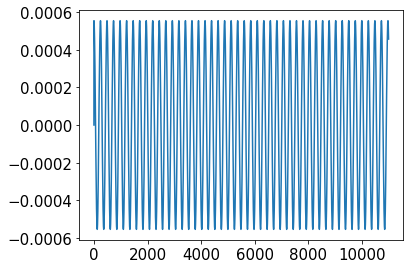

In [350]:
plt.plot(storedisplacementcurrent)

In [351]:
Cap

4.511486602840728e-12

## Current Voltage Waveform

[4200, 4800, -0.002, 0.002]

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


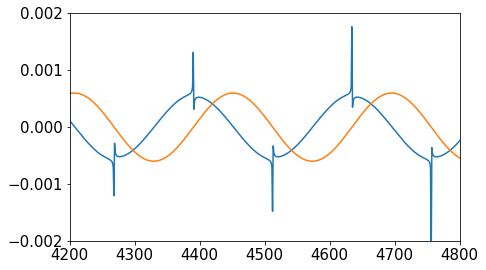

In [390]:
plt.figure(figsize=(7,4))
plt.plot((storecurrent+storedisplacementcurrent))
np.savetxt('current.out', -storecurrent[:])
np.savetxt('voltage.out', storepotentl[:,1])
plt.plot(storepotentl[:,1]/5000000)

plt.axis([4200,4800,-0.002,0.002])


/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


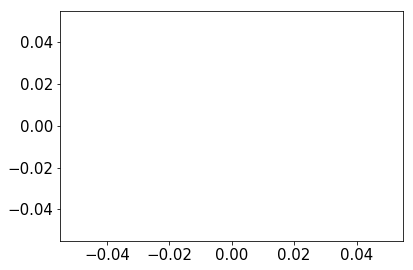

In [395]:
crnt=storecurrent+storedisplacementcurrent
plt.plot(crnt[5500:-5500])

## Growth of Electrons with time

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


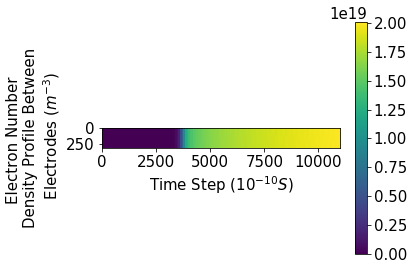

In [353]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
plt.imshow(np.transpose(storedensity),aspect=3)
plt.colorbar()
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Electron Number \nDensity Profile Between\n Electrodes $(m^{-3})$")
plt.savefig('electrondensity2D.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


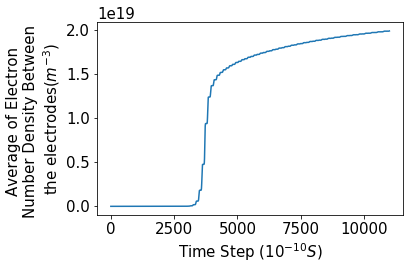

In [354]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
jodekoelectron=np.zeros(int(numberOfSteps/stepping),float)
for jodne in np.arange(int(numberOfSteps/stepping)):
    jodekoelectron[jodne]=np.sum(storedensity[jodne,:])
plt.plot((jodekoelectron/302))
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Average of Electron \nNumber Density Between \nthe electrodes$(m^{-3})$")
plt.savefig('electrondensity1d.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


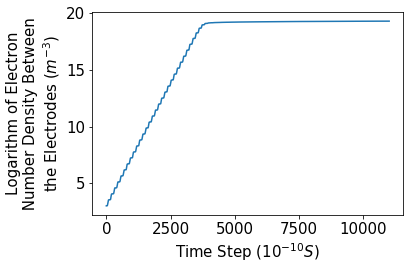

In [355]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
jodekoelectron=np.zeros(int(numberOfSteps/stepping),float)
for jodne in np.arange(int(numberOfSteps/stepping)):
    jodekoelectron[jodne]=np.sum(storedensity[jodne,:])
plt.plot(np.log10(jodekoelectron/302))
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Logarithm of Electron\n Number Density Between \nthe Electrodes $(m^{-3})$")
plt.savefig('logelectrondensity1d.jpg', format='jpg', dpi=1000)

The logarithmic plot of the number density of electron is a straight line which verifies that the growth of electron is exponential. 

### Growth of Ions with time

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


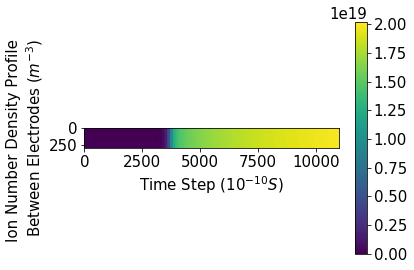

In [356]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
plt.imshow(np.transpose(storedensity2),aspect=3)
plt.colorbar()
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Ion Number Density Profile \nBetween Electrodes $(m^{-3})$")
plt.savefig('iondensity2d.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


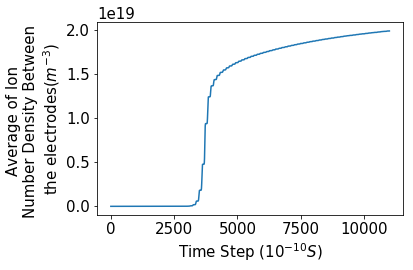

In [357]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
jodekoelectron=np.zeros(int(numberOfSteps/stepping),float)
for jodne in np.arange(int(numberOfSteps/stepping)):
    jodekoelectron[jodne]=np.sum(storedensity2[jodne,:])
plt.plot((jodekoelectron/302))
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Average of Ion \nNumber Density Between \nthe electrodes$(m^{-3})$")
plt.savefig('iondensity1d.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


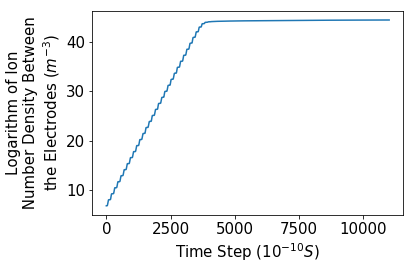

In [358]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
jodekoelectron=np.zeros(int(numberOfSteps/stepping),float)
for jodne in np.arange(int(numberOfSteps/stepping)):
    jodekoelectron[jodne]=np.sum(storedensity2[jodne,:])
plt.plot(np.log(jodekoelectron/302))
plt.xlabel("Time Step $(10^{-10}S)$")
plt.ylabel("Logarithm of Ion\n Number Density Between \nthe Electrodes $(m^{-3})$")
plt.savefig('logiondensity1d.jpg', format='jpg', dpi=1000)

In [359]:
np.log(jodekoelectron[250]/302)/250

0.037349217411266504

## Spatial Variation of Potential between the electrodes at a particular instant of time      $(t=7.2x10^{-8})$

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


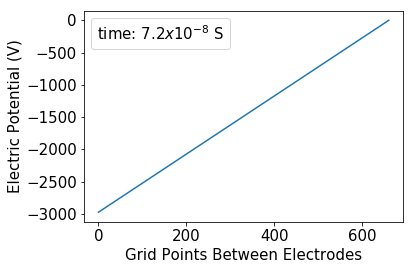

In [360]:
import matplotlib.lines as mlines
plt.rcParams.update({'font.size': 15})
plt.plot(storepotentl[920])
plt.xlabel("Grid Points Between Electrodes")
plt.ylabel("Electric Potential (V)")

plt.rcParams.update({'font.size': 15})
blue_line = mlines.Line2D([], [], marker='.',markersize=0, label='time: $7.2x10^{-8}$ S')
plt.legend(handles=[blue_line],handletextpad=.0, handlelength=0)

plt.savefig('voltageprofile.jpg', format='jpg', dpi=1000)

## Charge accumulation of the dielectric surface at$( t=7.2x10^{-8})$

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


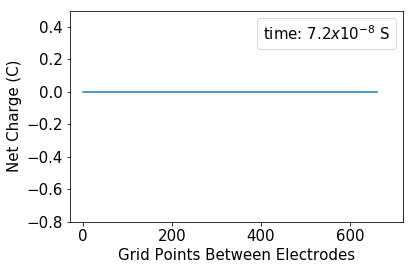

In [361]:
import matplotlib.lines as mlines
plt.rcParams.update({'font.size': 15})
plt.plot(storenetcharge[920])
plt.xlabel("Grid Points Between Electrodes")
plt.ylabel("Net Charge (C)")
plt.axis([-30,720,-0.8,0.5])

plt.rcParams.update({'font.size': 15})
blue_line = mlines.Line2D([], [], marker='',markersize=15, label='time: $7.2x10^{-8}$ S')
plt.legend(handles=[blue_line],handletextpad=.0, handlelength=0)
plt.savefig('voltageprofile.jpg', format='jpg', dpi=1000)

## Electron/ion density profiel at $t=7.2x10^{-8}$)

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


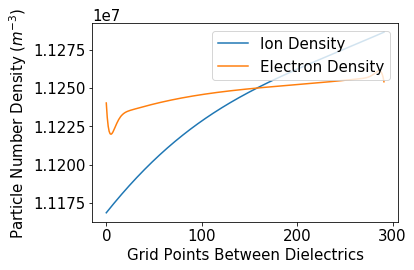

In [362]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
ax.plot(storedensity[920,5:-5], label='Ion Density')
ax.plot(storedensity2[920,5:-5], label='Electron Density')
#ax.axis([-10,310,5.4e18,5.9e18])
plt.xlabel("Grid Points Between Dielectrics")
plt.ylabel("Particle Number Density ($m^{-3}$)")
leg = ax.legend(loc=1);
plt.savefig('electronion.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


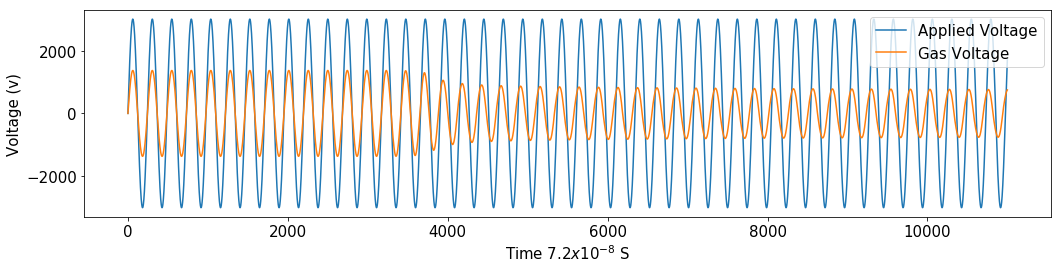

In [383]:
fig, ax = plt.subplots(figsize=(15, 4))
#ax.plot(storepotentl[800:1000,0], label='Applied Voltage')
#ax.plot((storepotentl[800:1000,nwd1]-storepotentl[800:1000,nwd1+1+ngrid0]), label='Voltage between dielectrics')
ax.plot(storepotentl[:,0], label='Applied Voltage')
ax.plot((storepotentl[:,nwd1]-storepotentl[:,nwd1+1+ngrid0]), label='Gas Voltage')

plt.xlabel('Time $7.2x10^{-8}$ S')

plt.ylabel('Voltage (v)')
hi=ax.legend(loc=1)
#ax.axis([-20,220,-5000,6099])
plt.savefig('internalexternalVoltage.jpg', format='jpg', dpi=1000)

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


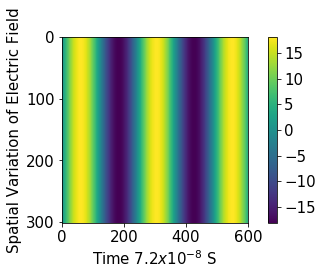

In [364]:
plt.imshow(np.transpose(storeefield[1:600]),aspect=1.99)
plt.xlabel('Time $7.2x10^{-8}$ S')
plt.ylabel('Spatial Variation of Electric Field')
plt.colorbar()

/home/saurav/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


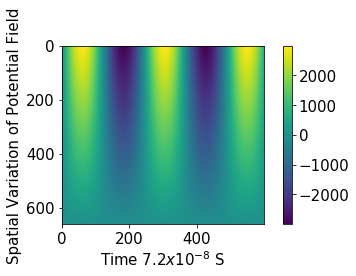

In [365]:
plt.imshow(np.transpose(storepotentl[1:600]),aspect=0.8)
plt.xlabel('Time $7.2x10^{-8}$ S')
plt.ylabel('Spatial Variation of Potential Field')
plt.colorbar()